In [4]:
import pandas as pd
import numpy as np
import json
import datetime
from prep_tools import columns_count
from collections import defaultdict
from tqdm import tqdm
import random
import sys
sys.path.insert(1,'../tools')
import utils
import imp

## Positive

In [2]:
timeline_dict = json.load(open('./result/pu_chart/timeline_dict_time.json','r'))

In [3]:
diff_list = []
exclude_key = []
for k,v in timeline_dict.items():
    adm_date = pd.to_datetime(v[1][0])
    pu_date = pd.to_datetime(v[1][1])
    diff = pu_date - adm_date
    diff_list.append(diff)
    if diff < datetime.timedelta(hours=24):
        exclude_key.append(k)
len(exclude_key)

1177

In [4]:
#在这一步把dict里面的日期都给变成datetime了，免得以后转换费时间
exclude_key = set(exclude_key)
AE_timeline_dict = defaultdict(lambda:[[],[]])
for k,v in timeline_dict.items():
    if k not in exclude_key:
        tmp_v = []
        for str_date in v[1]:
            tmp_v.append(pd.to_datetime(str_date))
        AE_timeline_dict[k][0] = v[0]
        AE_timeline_dict[k][1] = tmp_v

In [5]:
AE_timeline_dict[k]

[['admission_0',
  'Pressure Ulcer Stage #2',
  'Pressure Ulcer Stage #2',
  'Pressure Ulcer Stage #2',
  'discharge_11'],
 [Timestamp('2182-02-05 03:30:00'),
  Timestamp('2182-02-07 15:12:00'),
  Timestamp('2182-02-07 13:25:00'),
  Timestamp('2182-02-07 04:00:00'),
  Timestamp('2182-02-10 14:50:00')]]

In [6]:
#取PU 发病三天前。如果三天前还没住院就从住院开始
period_dict = {}
for k,v in AE_timeline_dict.items():
    start_date = pd.to_datetime(v[1][1]) - datetime.timedelta(hours = 72)
    if start_date < pd.to_datetime(v[1][0]):
        start_date = pd.to_datetime(v[1][0])
    period_dict[k] = start_date              

In [8]:
len(AE_timeline_dict)

4127

In [9]:
len(period_dict)

4127

In [10]:
#根据hadm_id 找到noteevent中所有和case有关的note
note_df = pd.read_csv('../data/NOTEEVENTS.csv',dtype = {'HADM_ID':str})

/home/zilong.zhang1/miniconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
pu_note = note_df[note_df['HADM_ID'].isin(AE_timeline_dict.keys())]

In [12]:
pu_note.shape

(326189, 11)

In [13]:
note_df.shape

(2083180, 11)

In [14]:
#选取里面CATEGORY 是nursing的
pu_nursing = pu_note[pu_note['CATEGORY'].isin(['Nursing','Nursing/other'])]

In [15]:
pu_nursing.shape

(155048, 11)

In [16]:
pu_nursing['ISERROR'].value_counts()

1.0    116
Name: ISERROR, dtype: int64

In [17]:
#去掉ISERROR为1的，去掉关键项有na的
noer_pu_nursing = pu_nursing[-(pu_nursing['ISERROR']==1)]
noer_pu_nursing = noer_pu_nursing.dropna(subset = ['HADM_ID','SUBJECT_ID','TEXT'])

In [18]:
noer_pu_nursing.shape

(154932, 11)

In [19]:
155048 - 154932

116

In [20]:
len(noer_pu_nursing['HADM_ID'].unique())

2537

In [21]:
nona_pu_nursing = noer_pu_nursing

In [22]:
pu_period_nursing = pd.DataFrame(columns = pu_nursing.columns)
row_list = []
for index,row in tqdm(nona_pu_nursing.iterrows()):
    key = row['HADM_ID']
    tmp_date = pd.to_datetime(row['CHARTTIME'])
    if tmp_date>= period_dict[key] and tmp_date < AE_timeline_dict[key][1][1]:
        #pu_period_nursing = pd.concat([pu_period_nursing,row])
        row_list.append(row)
pu_period_nursing = pd.concat(row_list,ignore_index=True,axis=1).T

154932it [00:25, 6092.84it/s]


In [23]:
len(row_list)

27011

In [24]:
pu_period_nursing.shape

(27011, 11)

In [25]:
pu_period_nursing.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,316480,31916,146431,2112-02-23,2112-02-23 03:51:00,2112-02-23 04:03:01,Nursing,Nursing Progress Note,14419,NaN,"Respiratory failure, acute (not ARDS/[**Doctor..."
1,316013,30015,150549,2154-03-20,2154-03-20 04:07:00,2154-03-20 04:18:24,Nursing,Nursing Progress Note,14419,NaN,"Respiratory failure, acute (not ARDS/[**Doctor..."
2,316390,31916,146431,2112-02-22,2112-02-22 06:25:00,2112-02-22 06:25:18,Nursing,Nursing Progress Note,14695,NaN,Chief Complaint: Nausea and vomiting\n HPI:...
3,316476,31916,146431,2112-02-23,2112-02-23 03:51:00,2112-02-23 03:51:34,Nursing,Nursing Progress Note,14419,NaN,"Respiratory failure, acute (not ARDS/[**Doctor..."
4,316479,31916,146431,2112-02-23,2112-02-23 03:51:00,2112-02-23 03:58:53,Nursing,Nursing Progress Note,14419,NaN,"Respiratory failure, acute (not ARDS/[**Doctor..."


In [28]:
row_list = []
for hid in tqdm(pu_period_nursing.HADM_ID.unique()):
    tmp_df = pu_period_nursing[pu_period_nursing.HADM_ID == hid]
    tmp_text = ' '.join(list(tmp_df.TEXT))
    row_list.append([hid,tmp_text])
pu_period_allnursing=pd.DataFrame(row_list,columns=['HADM_ID','text'])

100%|██████████| 2438/2438 [00:04<00:00, 540.92it/s]


In [29]:
pu_period_allnursing.head()

,HADM_ID,text
0,146431,"Respiratory failure, acute (not ARDS/[**Doctor..."
1,150549,"Respiratory failure, acute (not ARDS/[**Doctor..."
2,154590,NPN: Narrative Note: Preliminary Admit note:\n...
3,116532,Pt is a 86 y/o woman with history of severe AS...
4,177843,53 y/o male with esophageal cancer and h/o PE'...


In [43]:
imp.reload(utils)
clean_abb_text = utils.clean_Abb(20,list(pu_period_allnursing.text))

100%|██████████| 121/121 [00:00<00:00, 345.91it/s]


In [47]:
pu_period_allnursing['clean_text'] = clean_abb_text

In [48]:
import spacy

In [49]:
%%time
nlp = spacy.load("en_core_web_sm")
lemmatized_text = []
for doc in nlp.pipe(clean_abb_text, batch_size=10,n_process=20, disable=["parser", "ner"]):
    tmp_doc = [tok.lemma_ for tok in doc]
    tmp_doc = ' '.join(tmp_doc)
    lemmatized_text.append(tmp_doc)

CPU times: user 1min 39s, sys: 3.17 s, total: 1min 42s
Wall time: 1min 43s


In [53]:
pu_period_allnursing['lemma_text'] = lemmatized_text

In [54]:
pu_period_allnursing.iloc[0]

HADM_ID                                                  146431
text          Respiratory failure, acute (not ARDS/[**Doctor...
clean_text    Respiratory failure, acute (not ARDS/ ) Assess...
lemma_text    respiratory failure , acute ( not ards/ ) asse...
Name: 0, dtype: object

In [96]:
pu_period_allnursing['pu_label'] = 1

In [98]:
pu_period_allnursing.iloc[1]

HADM_ID                                                  150549
text          Respiratory failure, acute (not ARDS/[**Doctor...
clean_text    Respiratory failure, acute (not ARDS/ ) Assess...
lemma_text    respiratory failure , acute ( not ards/ ) asse...
pu_label                                                      1
Name: 1, dtype: object

In [26]:
#pu_period_nursing.to_csv('pu_period_nursing.csv')
#pu_period_nursing = pd.read_csv('./result/pu_chart/pu_period_nursing.csv')

## 放弃dict或者list作为存储方式

In [65]:
pu_adm_nurse_note = defaultdict(lambda:[])
for index,row in tqdm(pu_period_nursing.iterrows()):
    key = row['HADM_ID']
    pu_adm_nurse_note[key].append(row['TEXT'])
    

27011it [00:01, 15450.43it/s]


In [66]:
len(pu_adm_nurse_note)

2438

In [67]:
import json
json.dump(pu_adm_nurse_note,open('pu_adm_nurse_note.json','w'))

In [68]:
pu_adm_allnurse_note = {}
for k,v in pu_adm_nurse_note.items():
    pu_adm_allnurse_note[k] = ' '.join(v)

In [69]:
pos_text = list(pu_adm_allnurse_note.values())
pos_label = [1] * len(pos_text)

In [70]:
len_list = []
for k,v in pu_adm_nurse_note.items():
    len_list.append(len(v))

In [71]:
delta_list = []
for k,v in period_dict.items():
    if k in set(pu_adm_allnurse_note.keys()):
        delta_time = AE_timeline_dict[k][1][1] - v
        delta_list.append(delta_time)
    
delta_bin = [datetime.timedelta(days = 1),datetime.timedelta(days = 2),datetime.timedelta(days = 3),datetime.timedelta(days = 4)]
delta_bin_number = [0,0,0]
for tmp_delta in delta_list:
    if tmp_delta >= delta_bin[0] and tmp_delta< delta_bin[1]:
        delta_bin_number[0]+= 1
    elif tmp_delta >= delta_bin[1] and tmp_delta< delta_bin[2]:
        delta_bin_number[1]+= 1
    elif tmp_delta >= delta_bin[2] and tmp_delta< delta_bin[3]:
        delta_bin_number[2]+= 1

[380, 234, 1824]

In [61]:
np.sum(delta_bin_number)

2438

In [33]:
np.mean(len_list)

11.079163248564397

In [34]:
np.std(len_list)

6.301611233635398

In [35]:
np.quantile(len_list,0.10)

4.0

In [36]:
np.quantile(len_list,0.90)

19.0

## Negative

In [55]:
import pickle
pu_sub_ids = pickle.load(open('./result/pu_chart/pu_subject_ids.pkl','rb')) 
pu_sub_ids = set(pu_sub_ids)

In [56]:
nopu_note = note_df[-note_df['SUBJECT_ID'].isin(pu_sub_ids)]

In [57]:
nopu_nurse = nopu_note[nopu_note['CATEGORY'].isin(['Nursing','Nursing/other'])]

In [58]:
print(nopu_nurse.shape)

(799003, 11)


In [59]:
nopu_noerror_nurse = nopu_nurse[-(nopu_nurse['ISERROR'] == 1)]
print(nopu_noerror_nurse.shape)

(798808, 11)


In [60]:
799003 - 798808

195

In [61]:
print(nopu_noerror_nurse.shape)
nopu_noerror_nurse = nopu_noerror_nurse.dropna(subset = ['HADM_ID','SUBJECT_ID','TEXT']) 
print(nopu_noerror_nurse.shape)

(798808, 11)
(796243, 11)


In [62]:
adm_df = pd.read_csv('../data/ADMISSIONS.csv',dtype = {'HADM_ID':str})
print(adm_df.shape)
adm_df = adm_df.dropna(subset = ['ADMITTIME','DISCHTIME'])
adm_df = adm_df[-(adm_df['ADMISSION_TYPE'] == 'NEWBORN')]
print(adm_df.shape)

(58976, 19)
(51113, 19)


In [63]:
todrop_index = []
for index,row in adm_df.iterrows():
    if pd.to_datetime(row['DISCHTIME']) - pd.to_datetime(row['ADMITTIME'])< datetime.timedelta(hours = 24):
        #print(row)
        todrop_index.append(index)
adm_df = adm_df.drop(todrop_index)   

In [73]:
delta_bin_number = [380, 234, 1824]
neg_delta_bin_number = np.array(delta_bin_number)*3

In [74]:
len(nopu_noerror_nurse['HADM_ID'].unique())

36918

In [84]:
all_neg_adm_set = nopu_noerror_nurse['HADM_ID'].unique()

In [85]:
import datetime as dt
tmp_bin_number = [0,0,0]
all_neg_adm_set = set(nopu_noerror_nurse['HADM_ID'].unique())
neg_period_dict = defaultdict(lambda:[])
for index, row in adm_df.iterrows():
    tmp_id = row['HADM_ID']
    if tmp_id in all_neg_adm_set:
        tmp_adm = pd.to_datetime(row['ADMITTIME'])
        tmp_dis = pd.to_datetime(row['DISCHTIME'])
        tmp_delta = tmp_dis - tmp_adm
        tmp_hours = int(tmp_delta.total_seconds() / 3600)
        if tmp_bin_number[0] < neg_delta_bin_number[0]:
            dummy_pu_delta = random.randint(24,min(tmp_hours,48))
            dummy_pu = tmp_adm + dt.timedelta(hours = dummy_pu_delta)
            dummy_start = tmp_adm
            neg_period_dict[tmp_id].append(dummy_start)
            neg_period_dict[tmp_id].append(dummy_pu)
            tmp_bin_number[0]+=1
            continue
        if tmp_bin_number[1] < neg_delta_bin_number[1] and tmp_hours > 48:
            dummy_pu_delta = random.randint(24,min(tmp_hours,72))
            dummy_pu = tmp_adm + dt.timedelta(hours = dummy_pu_delta)
            dummy_start = tmp_adm
            neg_period_dict[tmp_id].append(dummy_start)
            neg_period_dict[tmp_id].append(dummy_pu)
            tmp_bin_number[1]+=1
            continue
        if tmp_bin_number[2] < neg_delta_bin_number[2] and tmp_hours > 72:
            dummy_pu_delta = random.randint(72,tmp_hours)
            dummy_pu = tmp_adm + dt.timedelta(hours = dummy_pu_delta)
            dummy_start = dummy_pu - dt.timedelta(hours = 72)
            neg_period_dict[tmp_id].append(dummy_start)
            neg_period_dict[tmp_id].append(dummy_pu)
            tmp_bin_number[2]+=1
            continue

In [86]:
row_list = []
for index,row in tqdm(nopu_noerror_nurse.iterrows()):
    key = row['HADM_ID']
    if key in neg_period_dict:
        tmp_date = pd.to_datetime(row['CHARTTIME'])
        if tmp_date>= neg_period_dict[key][0] and tmp_date < neg_period_dict[key][1]:
            #pu_period_nursing = pd.concat([pu_period_nursing,row])
            row_list.append(row)
nopu_period_nursing = pd.concat(row_list,ignore_index=True,axis=1).T

796243it [00:59, 13364.01it/s]


In [87]:
len(nopu_period_nursing['HADM_ID'].unique())

5156

In [88]:
nopu_period_nursing.shape

(26853, 11)

In [90]:
row_list = []
for hid in tqdm(nopu_period_nursing.HADM_ID.unique()):
    tmp_df = nopu_period_nursing[nopu_period_nursing.HADM_ID == hid]
    tmp_text = ' '.join(list(tmp_df.TEXT))
    row_list.append([hid,tmp_text])
nopu_period_allnursing=pd.DataFrame(row_list,columns=['HADM_ID','text'])
imp.reload(utils)
clean_abb_text = utils.clean_Abb(20,list(nopu_period_allnursing.text))
nopu_period_allnursing['clean_text'] = clean_abb_text
nlp = spacy.load("en_core_web_sm")
lemmatized_text = []
for doc in nlp.pipe(clean_abb_text, batch_size=10,n_process=20, disable=["parser", "ner"]):
    tmp_doc = [tok.lemma_ for tok in doc]
    tmp_doc = ' '.join(tmp_doc)
    lemmatized_text.append(tmp_doc)
nopu_period_allnursing['lemma_text'] = lemmatized_text

100%|██████████| 257/257 [00:00<00:00, 605.29it/s]


In [99]:
nopu_period_allnursing['pu_label'] = 0

In [100]:
all_period_allnursing = pd.concat([pu_period_allnursing,nopu_period_allnursing])

In [101]:
all_period_allnursing.shape

(7594, 5)

In [27]:
#both_period_allnursing即为all_period_allnursing，避免all_period带来的歧义。both指的是既有pos又有neg的both
both_period_allnursing.to_csv('./result/pu_chart/pu_chart_nursing_3day.csv')
both_period_allnursing = pd.read_csv('./result/pu_chart/pu_chart_nursing_3day.csv')

In [28]:
both_period_allnursing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7594 entries, 0 to 7593
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    7594 non-null   int64 
 1   Unnamed: 0.1  7594 non-null   int64 
 2   HADM_ID       7594 non-null   int64 
 3   text          7594 non-null   object
 4   clean_text    7594 non-null   object
 5   lemma_text    7594 non-null   object
 6   pu_label      7594 non-null   int64 
 7   split         7594 non-null   object
dtypes: int64(4), object(4)
memory usage: 474.8+ KB


In [9]:
ids_list = list(both_period_allnursing.HADM_ID)
label_list = list(both_period_allnursing.pu_label)

In [12]:
both_period_allnursing.head()

,Unnamed: 0,HADM_ID,text,clean_text,lemma_text,pu_label
0,0,146431,"Respiratory failure, acute (not ARDS/[**Doctor...","Respiratory failure, acute (not ARDS/ ) Assess...","respiratory failure , acute ( not ards/ ) asse...",1
1,1,150549,"Respiratory failure, acute (not ARDS/[**Doctor...","Respiratory failure, acute (not ARDS/ ) Assess...","respiratory failure , acute ( not ards/ ) asse...",1
2,2,154590,NPN: Narrative Note: Preliminary Admit note:\n...,NPN: Narrative Note: Preliminary Admit note: 6...,NPN : Narrative note : Preliminary Admit note ...,1
3,3,116532,Pt is a 86 y/o woman with history of severe AS...,Pt is a 86 y/o woman with history of severe AS...,Pt be a 86 y / o woman with history of severe ...,1
4,4,177843,53 y/o male with esophageal cancer and h/o PE'...,53 y/o male with esophageal cancer and h/o PE'...,53 y / o male with esophageal cancer and h / o...,1


In [10]:
label_list[:5]

[1, 1, 1, 1, 1]

In [11]:
ids_list[:5]

[146431, 150549, 154590, 116532, 177843]

In [22]:
from sklearn.model_selection import train_test_split
train_indices,test_indices,train_label,test_label = train_test_split(ids_list,label_list,test_size = 0.2,stratify =label_list,random_state = 221)

In [23]:
train_indices = set(train_indices) 
test_indices = set(test_indices) 

In [24]:
split_list = []
for k in both_period_allnursing.HADM_ID:
    if k in train_indices:
        split_list.append('train')
    else:
        split_list.append('test')
split_list[:20]

['train',
 'train',
 'test',
 'test',
 'train',
 'train',
 'test',
 'train',
 'train',
 'train',
 'test',
 'train',
 'train',
 'test',
 'train',
 'train',
 'train',
 'train',
 'test',
 'train']

In [25]:
both_period_allnursing['split'] = split_list

In [26]:
both_period_allnursing.head()

,Unnamed: 0,HADM_ID,text,clean_text,lemma_text,pu_label,split
0,0,146431,"Respiratory failure, acute (not ARDS/[**Doctor...","Respiratory failure, acute (not ARDS/ ) Assess...","respiratory failure , acute ( not ards/ ) asse...",1,train
1,1,150549,"Respiratory failure, acute (not ARDS/[**Doctor...","Respiratory failure, acute (not ARDS/ ) Assess...","respiratory failure , acute ( not ards/ ) asse...",1,train
2,2,154590,NPN: Narrative Note: Preliminary Admit note:\n...,NPN: Narrative Note: Preliminary Admit note: 6...,NPN : Narrative note : Preliminary Admit note ...,1,test
3,3,116532,Pt is a 86 y/o woman with history of severe AS...,Pt is a 86 y/o woman with history of severe AS...,Pt be a 86 y / o woman with history of severe ...,1,test
4,4,177843,53 y/o male with esophageal cancer and h/o PE'...,53 y/o male with esophageal cancer and h/o PE'...,53 y / o male with esophageal cancer and h / o...,1,train


## 放弃dict或者list作为存储方式

In [83]:
neg_adm_nurse_note = defaultdict(lambda:[])
for index,row in tqdm(nopu_period_nursing.iterrows()):
    key = row['HADM_ID']
    neg_adm_nurse_note[key].append(row['TEXT'])

NameError: name 'nopu_period_nursing' is not defined

In [158]:
len_list = []
for k,v in neg_adm_nurse_note.items():
    len_list.append(len(v))
print(np.mean(len_list))
print(np.quantile(len_list,0.25))
print(np.quantile(len_list,0.75))

5.1439263097294186
2.0
7.0


In [163]:
json.dump(neg_adm_nurse_note,open('neg_adm_nurse_note_periodmatch.json','w'))

In [139]:
tmp_bin_number

[950, 585, 4560]

In [142]:
random.choice(list(neg_period_dict.values()))

[Timestamp('2122-01-05 01:55:00'), Timestamp('2122-01-08 01:55:00')]

In [129]:
int(aaa.total_seconds() / 3600)

38

In [131]:
random.randint(1,38)

27

In [124]:
aaa.seconds

52500

In [ ]:
for index,row in adm_df.iterrows():
    

In [81]:
pd.to_datetime(row['DISCHTIME']) - pd.to_datetime(row['ADMITTIME'])<datetime.timedelta(hours = 24)

False

In [75]:
len(todrop_index)

2065

In [ ]:
adm_df = adm_df.drop(todrop_index)

In [47]:
neg_adm_set = set(neg_adm_list)
neg_date_dict = defaultdict(lambda:[])
for index,row in tqdm(adm_df.iterrows()):
    key = row['HADM_ID']
    if key in neg_adm_set:
        neg_date_dict[key].append(row['ADMITTIME'])
        neg_date_dict[key].append(row['DISCHTIME'])

51113it [00:03, 15146.62it/s]


In [48]:
neg_date_dict[neg_adm_list[0]]

['2144-02-01 01:58:00', '2144-02-03 18:01:00']

In [105]:
mu, sigma = 11, 6 # mean and standard deviation
doc_nums = np.round(np.random.normal(11,6,2*2438))
np.clip(doc_nums,4,19)
count = 0
neg_dict = {}
for neg_adm in neg_adm_list:
    if len(neg_adm_nurse_note[neg_adm]) > doc_nums[count]:
        neg_dict[neg_adm] = random.choices(neg_adm_nurse_note[neg_adm],k = int(doc_nums[count]))
    else:
        neg_dict[neg_adm] = neg_adm_nurse_note[neg_adm]                              

In [106]:
len(neg_dict)

4876

In [107]:
json.dump(neg_dict,open('neg_adm_nurse_note.json','w'))

In [108]:
neg_dict = json.load(open('neg_adm_nurse_note.json','r'))
print(len(neg_dict))

4876


In [113]:
neg_adm_allnurse_note = {}
for k,v in neg_dict.items():
    neg_adm_allnurse_note[k] = ' '.join(v)

In [114]:
len(neg_adm_allnurse_note)

4876

In [115]:
neg_text = list(neg_adm_allnurse_note.values())
neg_label = [0] * len(neg_text)

In [36]:
nopu_noerror_nurse.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
308705,316320,28742,185325.0,2144-02-02,2144-02-02 07:27:00,2144-02-02 07:27:11,Nursing,Nursing Transfer Note,15065.0,NaN,73 y/o female with breast cancer metastatic to...
308711,316402,29076,193948.0,2151-02-08,2151-02-08 03:07:00,2151-02-08 07:19:55,Nursing,Nursing Progress Note,20063.0,NaN,"Respiratory failure, acute (not ARDS/[**Doctor..."
308715,317749,29959,167558.0,2117-02-02,2117-02-02 03:10:00,2117-02-02 03:10:38,Nursing,Nursing Progress Note,15526.0,NaN,"Thromboembolism, other\n Assessment:\n Act..."
308716,317750,27866,109679.0,2143-04-09,2143-04-09 03:22:00,2143-04-09 03:22:26,Nursing,Nursing Progress Note,21297.0,NaN,Ms. [**Known lastname 1170**] is an 83 yo F w/...
308717,317751,27866,109679.0,2143-04-09,2143-04-09 03:22:00,2143-04-09 03:27:59,Nursing,Nursing Progress Note,21297.0,NaN,Ms. [**Known lastname 1170**] is an 83 yo F w/...


# 一点ML的实验

In [175]:
pu_adm_nurse_note = json.load(open('pu_adm_nurse_note.json','r'))
neg_dict = json.load(open('neg_adm_nurse_note_periodmatch.json','r'))
print(len(pu_adm_nurse_note))
print(len(neg_dict))

pu_adm_allnurse_note = {}
for k,v in pu_adm_nurse_note.items():
    pu_adm_allnurse_note[k] = ' '.join(v)
    
neg_adm_allnurse_note = {}
for k,v in neg_dict.items():
    neg_adm_allnurse_note[k] = ' '.join(v)
    
pos_text = list(pu_adm_allnurse_note.values())
pos_label = [1] * len(pos_text)
neg_text = list(neg_adm_allnurse_note.values())
neg_label = [0] * len(neg_text)

2438
5211


In [176]:
pos_text.extend(neg_text) 
pos_label.extend(neg_label) 
total_text = pos_text
total_label = pos_label

In [177]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
from sklearn.linear_model import LogisticRegression

In [178]:
text_train,text_test,Y_train,Y_test = train_test_split(total_text,total_label,test_size = 0.2,stratify = total_label,random_state=221)

In [179]:
type(text_train[0])

str

In [180]:
type(text_train)

list

In [181]:
Count_vectorizer = CountVectorizer(min_df =5,stop_words='english',max_df = 0.8)
Count_vectorizer = Count_vectorizer.fit(text_train)
X_train = Count_vectorizer.transform(text_train)
X_test = Count_vectorizer.transform(text_test)
print(np.shape(X_train))

(6119, 15431)


In [182]:
len(total_text) * 0.8

6119.200000000001

In [203]:
clf = ComplementNB()
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba,axis=-1)
print(classification_report(Y_test, y_pred, target_names=['No_pressure_ulcer','pressure_ulcer']))
print(confusion_matrix(Y_test,y_pred))
print(roc_auc_score(Y_test, y_pred))

                   precision    recall  f1-score   support

No_pressure_ulcer       0.82      0.97      0.89      1042
   pressure_ulcer       0.88      0.54      0.67       488

         accuracy                           0.83      1530
        macro avg       0.85      0.75      0.78      1530
     weighted avg       0.84      0.83      0.82      1530

[[1006   36]
 [ 224  264]]
0.7532173311097826


In [190]:
coef = clf.coef_[0]
np.sort(coef)

array([ 4.99443117,  5.36158799,  5.3938428 , ..., 14.65240174,
       14.65240174, 14.65240174])

In [194]:
np.argsort(coef)[-100:]

array([13600, 11473,  7094, 13955,  1892, 11705,  9642,  2945, 13902,
       13916,  4998,  7974,  7975,  7979, 10869,  6169,  6163, 14938,
        2497,  2499,  4836, 14826,  2508,  2510, 14298, 10357,  1492,
       14949, 14799,  2287, 14338,  7581, 10488,  2352,  4907, 10697,
       10734, 12287,  7790, 10587,  7700,  4048,  6270,  7838,  4025,
        7845, 14198, 10781,  7872,  2311,   659, 14923,   665,  5240,
        2576,  1463,  8537,   142,  2795,   806, 11098,   525,  4916,
        7267, 12934,  9794,  6643,  8641,  4402,  4744,  7256,  8672,
         246, 11942,  8761, 11091,  7456,  9938, 14399,  6522,  1461,
       12069,  1457,  2667,  1447,  1720,  3751,  7407, 12730,  7397,
       10999, 13891, 12773,  3699,  1392,  2704, 12016, 11052,  2748,
        2081])

In [197]:
count_vocab = Count_vectorizer.get_feature_names()

In [201]:
count_vocab[12016]

'regurgitation'

In [193]:
coef[np.argsort(coef)[-1]]

14.65240174195995

In [184]:
from sklearn import svm

SVC_clf = svm.SVC(class_weight = 'balanced',kernel = 'linear',probability=1)
SVC_clf.fit(X_train,Y_train)
y_pred = SVC_clf.predict(X_test)

y_pred_proba = SVC_clf.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba,axis=-1)

In [185]:
print(classification_report(Y_test, y_pred, target_names=['No_pressure_ulcer','pressure_ulcer']))
print(confusion_matrix(Y_test,y_pred))
print(roc_auc_score(Y_test, y_pred))

                   precision    recall  f1-score   support

No_pressure_ulcer       0.85      0.96      0.90      1042
   pressure_ulcer       0.88      0.63      0.74       488

         accuracy                           0.85      1530
        macro avg       0.86      0.80      0.82      1530
     weighted avg       0.86      0.85      0.85      1530

[[1000   42]
 [ 180  308]]
0.7954202196280797


In [202]:
lr_clf = LogisticRegression(class_weight='balanced',max_iter=1000)
lr_clf.fit(X_train,Y_train)
y_pred = lr_clf.predict(X_test)
y_pred_proba = lr_clf.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba,axis=-1)
print(classification_report(Y_test, y_pred, target_names=['No_pressure_ulcer','pressure_ulcer']))
print(confusion_matrix(Y_test,y_pred))
print(roc_auc_score(Y_test, y_pred))

                   precision    recall  f1-score   support

No_pressure_ulcer       0.90      0.93      0.91      1042
   pressure_ulcer       0.84      0.78      0.81       488

         accuracy                           0.88      1530
        macro avg       0.87      0.86      0.86      1530
     weighted avg       0.88      0.88      0.88      1530

[[967  75]
 [105 383]]
0.8564295491016645


In [209]:
coef = lr_clf.coef_[0]
kws = np.argsort(coef)[-50:]
for www in kws:
    print(count_vocab[www])

arrival
80cc
motor
cop
wide
weak
po2
cvvhd
hrs
tap
digoxin
intervention
uncomfortable
weakly
assessment
anuric
loose
paged
qtt
provide
mrsa
eyes
phenylephrine
45cc
colored
healing
treatment
specifics
black
allevyn
mcg
packing
bath
movements
rhonchi
purulent
ulcers
platelets
sacral
rehab
neuropathy
sore
cc7
cvicu
ulcer
stage
decub
heel
duoderm
coccyx


In [211]:
print(pos_text[0])

Respiratory failure, acute (not ARDS/[**Doctor Last Name **])
   Assessment:
   Remains intubated and vented. Continued on AC mode. Urine output 25-40
   cc/hr.
   Action:
   No change on  vent settings overnight.  Urine output not improved well
   Inspite of fluid boluses .
   Response:
   Vital signs remained stable. f/ u with am  blood gas.
   Plan:
   Continue vnet/ sedation  in view of her present surgical status.
   Small bowel obstruction (Intestinal obstruction, SBO, including
   intussusception, adhesions)
   Assessment:
   NGT asp  minimal, tube patent.  No N / V. no BM.
   Action:
   NGT flushed , connected to low suction. Seen by surgeons.
   Response:
   Less than 100cc drained.
   Plan:
   Per surgeon pt family is willing for  surgery now, so may  go for
   surgery today.
 Chief Complaint:  Nausea and vomiting
   HPI:
   Ms. [**Known lastname 823**] is a 60 yo F w/PMHx sx for metastatic RCC (liver, brain,
   lungs) on Avastin, on 3L home oxygen who presents to the ED with

In [206]:
kws

array([0.32527859, 0.327768  , 0.32853581, 0.32860619, 0.32864149,
       0.32909185, 0.329693  , 0.33100702, 0.33301927, 0.33326778,
       0.33514736, 0.33722366, 0.33918527, 0.3412492 , 0.3433861 ,
       0.34344362, 0.34349066, 0.34375526, 0.34768779, 0.34828689,
       0.34959485, 0.3513882 , 0.35188511, 0.35267385, 0.35407817,
       0.35431252, 0.35520595, 0.35590191, 0.35612902, 0.35649288,
       0.3573212 , 0.35787236, 0.35803026, 0.35841355, 0.36093048,
       0.36147403, 0.36511315, 0.36649697, 0.36842716, 0.36873606,
       0.36875712, 0.37015932, 0.37175124, 0.37244649, 0.3728417 ,
       0.37316889, 0.37342997, 0.37446139, 0.37838048, 0.37949943,
       0.38234668, 0.38411882, 0.38425927, 0.38702524, 0.38756797,
       0.38923358, 0.38951434, 0.39009184, 0.39031649, 0.39891897,
       0.40833424, 0.41018964, 0.4114598 , 0.41318644, 0.4149115 ,
       0.41516767, 0.41616215, 0.41689737, 0.41804461, 0.42052856,
       0.42113861, 0.42149137, 0.42240642, 0.43148792, 0.43800

In [ ]:
count_vocab

0.0


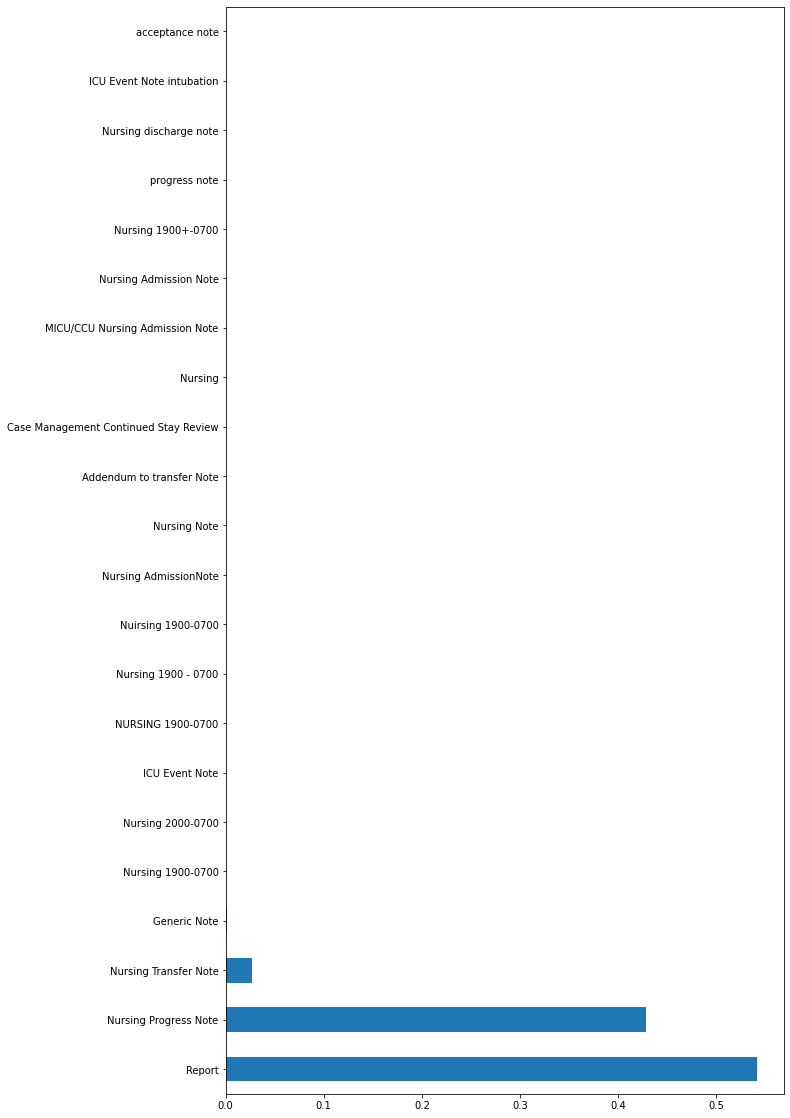

In [67]:
columns_count(pu_nursing,'DESCRIPTION')

0.0


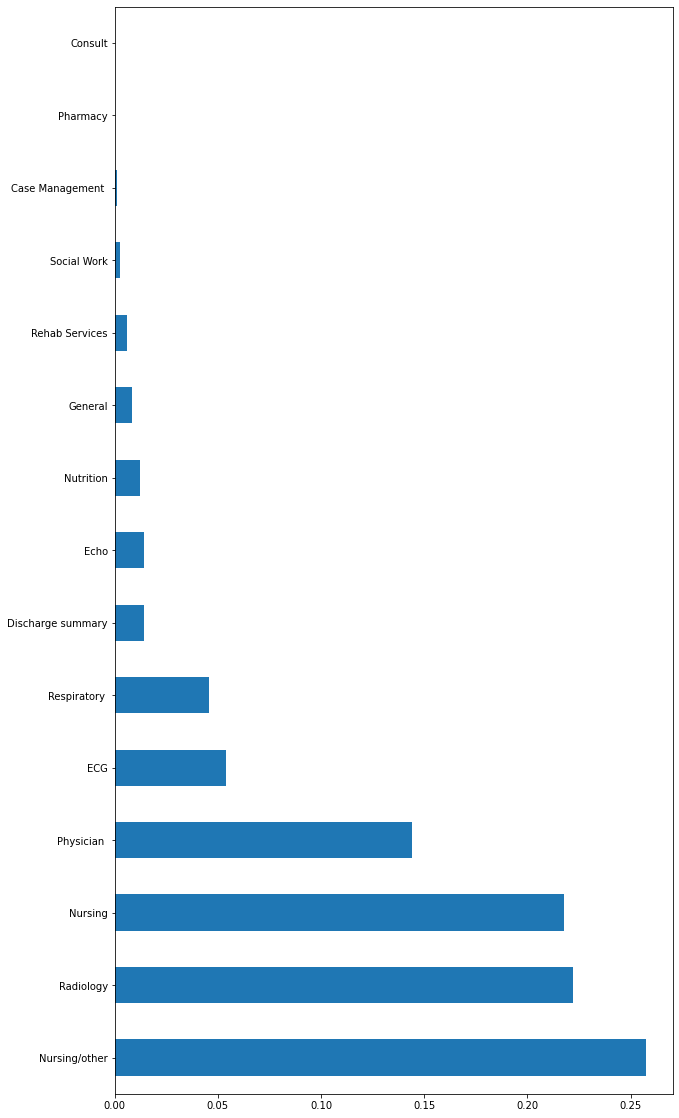

In [37]:
columns_count(pu_note,'CATEGORY')